In [1]:
WANDB=True

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import wandb
from fastai.vision.all import *
from self_supervised.augmentations import *
from self_supervised.layers import *
from self_supervised.vision.swav import *
from fastai.callback.wandb import WandbCallback
import random

from sklearn.model_selection import StratifiedKFold

In [4]:
path = Path("/home/mu/.fastai/data/rice-disease-classification/")
image_path = path/"images"
files = get_image_files(image_path)

In [5]:
train_df = pd.read_csv(path/"Train.csv")
test_df = pd.read_csv(path/"Test.csv")
sample_df = pd.read_csv(path/"SampleSubmission.csv")

In [6]:
train_df.Label.unique()

array(['blast', 'brown', 'healthy'], dtype=object)

In [7]:
test_df.head()

,Image_id
0,id_00vl5wvxq3.jpg
1,id_00vl5wvxq3_rgn.jpg
2,id_01hu05mtch.jpg
3,id_01hu05mtch_rgn.jpg
4,id_030ln10ewn.jpg


In [8]:
sample_df.head()

,Image_id,blast,brown,healthy
0,id_00vl5wvxq3.jpg,0.0,0.0,0.0
1,id_01hu05mtch.jpg,0.0,0.0,0.0
2,id_030ln10ewn.jpg,0.0,0.0,0.0
3,id_03z57m8xht.jpg,0.0,0.0,0.0
4,id_04ngep1w4b.jpg,0.0,0.0,0.0


In [9]:
size=128
bs=64

In [10]:
clas_block = DataBlock()
train_ds = clas_block.datasets(train_df)

In [11]:
def get_x(r): return r["Image_id"]
def get_y(r): return r["Label"]

In [12]:
clas_block = DataBlock(blocks=(ImageBlock, CategoryBlock),
                       splitter=RandomSplitter(seed=42),
                       get_x=ColReader(0, pref=image_path),
                       get_y=ColReader("Label"),
                       item_tfms=Resize(size),
                       batch_tfms=aug_transforms())

In [13]:
dls = clas_block.dataloaders(train_df, bs=bs)

In [14]:
test_dl = dls.test_dl(test_df, bs=32)

In [15]:
test_dl.n

2290

In [16]:
dls.c

3

In [17]:
dls.cuda()

In [18]:
# train_dl.show_batch()

In [19]:
# %pdb

In [20]:
optdict = dict(sqr_mom=0.99,mom=0.95,beta=0.,eps=1e-4)
opt_func = partial(ranger, **optdict)

In [21]:
arch = "xresnet34"

In [22]:
swav_encoder = "models/run-mwalimu-128-swav-xresnet34-pretrain-rice-disease-epc447-sz128px-bs32_encoder.pth"

In [23]:
if WANDB:
    xtra_config = {"Arch": arch, "Resize": size, "Algorithm": "Pretrained SWAV", "Epochs": 100, "Size": size, "Pretrained": True, "Batch Size": bs}
    wandb.init(project="self-supervised-rice-disease-classification", config=xtra_config);

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


In [25]:
def split_func(m): return L(m[0], m[1]).map(params)

def create_learner(dls, arch='xresnet34', encoder_path="models/swav-pretrain-rice-disease-epc37_encoder.pth"):
    pretrained_encoder = torch.load(encoder_path)
    encoder = create_encoder(arch, pretrained=False, n_in=3)
    encoder.load_state_dict(pretrained_encoder)
    nf = encoder(torch.randn(2,3,224,224)).size(-1)
    classifier = create_cls_module(nf, dls.c)
    model = nn.Sequential(encoder, classifier)
    learn = Learner(dls, model, opt_func=opt_func, splitter=split_func,
                metrics=[accuracy], loss_func=LabelSmoothingCrossEntropy(),
                    cbs=[SaveModelCallback(fname="classifier-best-{arch}-sz{size}"),
                         EarlyStoppingCallback(patience=10)])
    return learn

In [26]:
learn = create_learner(dls, encoder_path=swav_encoder)

SuggestedLRs(valley=0.00363078061491251)

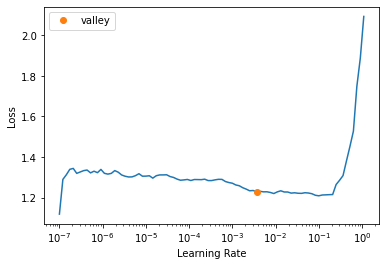

In [27]:
learn.lr_find()

In [28]:
learn.unfreeze()

In [29]:
learn.fit_one_cycle(100, 1e-2, wd=1e-3, moms=(0.95, 0.85, 0.95))

epoch,train_loss,valid_loss,accuracy,time
0,1.092954,0.943749,0.596442,00:36
1,0.955906,0.857881,0.686330,00:37
2,0.898021,0.851287,0.693820,00:36
3,0.850454,0.781105,0.713483,00:35
4,0.815781,0.757779,0.751873,00:36
5,0.792286,0.719789,0.753745,00:36
6,0.755525,0.702249,0.750936,00:36
7,0.751816,0.711067,0.753745,00:36
8,0.753194,0.839549,0.702247,00:36
9,0.757462,0.804237,0.737828,00:36


Better model found at epoch 0 with valid_loss value: 0.9437486529350281.
Better model found at epoch 1 with valid_loss value: 0.8578810691833496.
Better model found at epoch 2 with valid_loss value: 0.8512871265411377.
Better model found at epoch 3 with valid_loss value: 0.7811051607131958.
Better model found at epoch 4 with valid_loss value: 0.7577792406082153.
Better model found at epoch 5 with valid_loss value: 0.7197889089584351.
Better model found at epoch 6 with valid_loss value: 0.7022491693496704.
No improvement since epoch 6: early stopping


In [31]:
run_name = wandb.run.name
family = "swav-pretrain"
save_name = f'classifier-{run_name}-{arch}-{family}-rice-disease-epc{6}-sz{size}px-bs{bs}'
learn.save(save_name)

Path('models/classifier-dutiful-music-30-xresnet34-swav-pretrain-rice-disease-epc6-sz128px-bs32.pth')

wandb: Network error (ReadTimeout), entering retry loop.
wandb: Network error (ReadTimeout), entering retry loop.
wandb: Network error (ConnectionError), entering retry loop.
wandb: Network error (ReadTimeout), entering retry loop.
wandb: Network error (ConnectionError), entering retry loop.
wandb: Network error (ConnectionError), entering retry loop.


In [ ]:
def finetune(size, epochs, arch, encoder_path, lr=1e-2, wd=1e-2):
    learn = create_learner(size, arch, swav_encoder)
    learn.unfreeze()
    learn.fit_flat_cos(epochs, lr, wd=wd)
    final_acc = learn.recorder.values[-1][-2]
    return final_acc